# Import các thư viện cần thiết

In [697]:
import pandas as pd
from itables import show
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import skew,boxcox_normmax, zscore
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
import os

# Load dữ liệu

In [698]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Góp 2 dataset train và test để cùng đồng bộ về thứ tự và số lượng đặc trưng 

In [ ]:
#Chúng ta phải biến đổi biến mục tiêu.
# Biến đổi Logarit có vẻ phù hợp hơn, do đó chúng ta áp dụng biến đổi logarit cho cột 'SalePrice'.
y = np.log(train["SalePrice"])
data = pd.concat([train.drop("SalePrice",axis=1),test])
print("\n train",train.shape)
print("\n test",test.shape)
print("\nall_data",data.shape)


 train (1460, 81)

 test (1459, 80)

all_data (2919, 80)


# Tiền xử lý dữ liệu

## Dữ liệu phân loại:

Các biến này trong mô tả là có Na tức là không có chứ không phải vì thiếu dữ liệu nên để là NaN. Vì vậy sẽ chuyển NaN trong các đặc trưng dưới đây thành 'None'

In [700]:
features_nonefill = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                     "GarageCond", "GarageQual", "GarageFinish", "GarageType", 
                     "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
#chuyển NaN thành 'None'
data[features_nonefill] = data[features_nonefill].fillna("None")

Thay thế các giá trị thiếu của các đặc trưng dưới đây bằng cách sử dụng .Mode() do các biến này không phải là số. Ta sẽ điền các giá trị thiếu này bằng Mode và nhóm với neighborhood

In [701]:
features_modefill = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", 
                     "Exterior2nd", "SaleType", "Electrical", "KitchenQual", 
                     "Functional"]

data[features_modefill].isna().sum()

MasVnrType     1766
MSZoning          4
Utilities         2
Exterior1st       1
Exterior2nd       1
SaleType          1
Electrical        1
KitchenQual       1
Functional        2
dtype: int64

In [702]:
# Lặp qua từng cột và áp dụng .transform() riêng lẻ
for col in features_modefill:
    # Tính mode tổng thể của cột (dùng làm giá trị mặc định nếu mode nhóm rỗng)
    global_mode = data[col].mode()[0]
    
    # Áp dụng .transform()
    data[col] = data.groupby("Neighborhood")[col].transform(
        # Hàm lambda đã sửa:
        lambda x: x.fillna(
            # Kiểm tra xem mode của nhóm có rỗng hay không (xảy ra khi tất cả là NaN)
            x.mode()[0] if not x.mode().empty else global_mode
        )
    )

In [703]:
data[features_modefill].isna().sum()

MasVnrType     0
MSZoning       0
Utilities      0
Exterior1st    0
Exterior2nd    0
SaleType       0
Electrical     0
KitchenQual    0
Functional     0
dtype: int64

## Dữ liệu số:

Xử lý giá trị thiếu bằng trung vị của đặc trưng

In [704]:
features_medianfill = ["GarageArea", "LotFrontage"]
data[features_medianfill].isna().sum()

GarageArea       1
LotFrontage    486
dtype: int64

In [705]:

#gán NA bằng "median"
data[features_medianfill] = data.groupby("Neighborhood")[features_medianfill].transform(lambda x: x.fillna(x.median())) #grouping by Neighborhood

In [706]:
data[features_medianfill].isna().sum()

GarageArea     0
LotFrontage    0
dtype: int64

Chuyển các NaN của đặc trưng này thành '0' vì các đặc trưng này mà NaN thì tức là không có

In [707]:
features_zerofill = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", 
                     "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
data[features_zerofill].isna().sum()

GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
dtype: int64

In [708]:

#filling NA with 0
data[features_zerofill] = data[features_zerofill].fillna(0)

## Feature Engineering

Tạo các đặc trưng mới từ các đặc trưng cũ để tạo ra các đặc trưng có ý nghĩa với mô hình

In [709]:
#Areas
data["TotalArea"] = data["GrLivArea"] + data["TotalBsmtSF"]
data["TotalBaths"] = data["FullBath"] + data["BsmtFullBath"] + 0.5*(data["HalfBath"]+data["BsmtHalfBath"])
data["TotalPorch"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]

In [710]:
data[['TotalArea','TotalBaths','TotalPorch']]

,TotalArea,TotalBaths,TotalPorch
0,2566.0,3.5,61
1,2524.0,2.5,0
2,2706.0,3.5,42
3,2473.0,2.0,307
4,3343.0,3.5,84
...,...,...,...
1454,1638.0,1.5,0
1455,1638.0,1.5,24
1456,2448.0,2.0,0
1457,1882.0,1.5,32


Thông qua quan xét các đặc trưng 'PoolArea', '2ndFlrSF', 'GarageCars',... Tạo ra thêm các đặc trưng mang tính logic (0 không, 1 có).

In [711]:
#Logical features
data['Pool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['Garage'] = data['GarageCars'].apply(lambda x: 1 if x > 0 else 0)
data['Bsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['Fireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
data['Porch'] = data['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)

In [712]:
show(data[['Pool','2ndFloor','Garage','Bsmt','Fireplace','Porch']])

Loading ITables v2.5.2 from the internet... (need help?)


## Chuyển đổi kiểu dữ liệu và chuẩn hóa đặc trưng

### Chuyển đổi kiểu dữ liệu (Data transformation)

Thông qua quan sát ta thấy: 

MSSubClass đại diện cho loại hình nhà ở trong tập dữ liệu. Tuy là số nguyên như 20,40 nhưng mà đây cũng chỉ là mã nên ta sẽ chuyển về dtype category

YrSold là năm bán. Tuy là số nhưng cũng nên để nó là category thay vì để số nguyên. Vì nó là năm

In [713]:
data[["MSSubClass", "YrSold"]] = data[["MSSubClass", "YrSold"]].astype("category")

In [714]:
data[['MSSubClass','YrSold']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MSSubClass  2919 non-null   category
 1   YrSold      2919 non-null   category
dtypes: category(2)
memory usage: 29.4 KB


MoSold là tháng bán (từ 1 đến 12). Vấn đề là tháng 12 và tháng 1 thực tế là gần nhau nhất, nhưng nếu mô hình coi chúng là số nguyên, khoảng cách giữa 12 và 1 sẽ lớn nhất. Để khắc phục ta chiếu MoSold lên một vòng tròn đơn vị (Unit Circle) và sử dụng hàm lượng giác để tạo ra hai biến mới, đại diện cho tọa độ X và Y trên vòng tròn đó.

In [715]:
data["MoSoldsin"] = np.sin(2 * np.pi * data["MoSold"] / 12) #Hàm Sin
data["MoSoldcos"] = np.cos(2 * np.pi * data["MoSold"] / 12) #Hàm Cosin
data = data.drop("MoSold", axis=1)

In [716]:
show(data[['MoSoldsin','MoSoldcos']])

Loading ITables v2.5.2 from the internet... (need help?)


C:\Users\Admin\AppData\Local\Temp\ipykernel_26008\3958888435.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_skew.index, y=high_skew.values, palette="viridis")


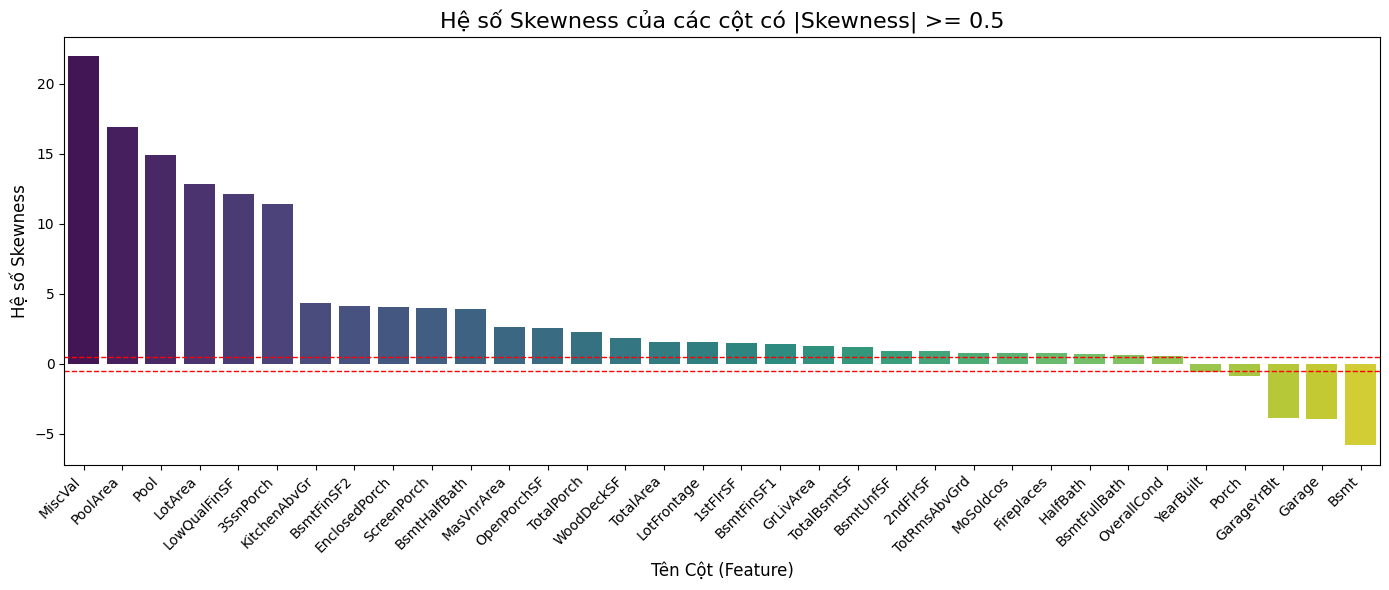

In [717]:
# --- 1. Tính toán Độ Lệch (Skewness) ---

# Chỉ chọn các cột có kiểu dữ liệu là số (định lượng) để tính Skewness
numeric_features = data.select_dtypes(include=np.number).columns

# Tính hệ số độ lệch cho từng cột định lượng
# Loại trừ cột mục tiêu (ví dụ: 'SalePrice') nếu nó có trong danh sách
features_to_check = [col for col in numeric_features if col not in ['SalePrice', 'Id']] 

# Tính toán Skewness
skewness_series = data[features_to_check].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# --- 2. Lọc và Trực quan hóa Độ Lệch Cao ---

# Đặt ngưỡng để lọc các cột có độ lệch đáng kể (ví dụ: |Skewness| > 0.5)
skewness_threshold = 0.5

# Lấy các cột có giá trị tuyệt đối của độ lệch lớn hơn ngưỡng
high_skew = skewness_series[abs(skewness_series) >= skewness_threshold]
# --- 3. Vẽ Biểu đồ Bar Plot ---

plt.figure(figsize=(14, 6))

# Tạo biểu đồ Bar Plot sử dụng Seaborn
sns.barplot(x=high_skew.index, y=high_skew.values, palette="viridis")

# Đặt tiêu đề và nhãn
plt.title(f'Hệ số Skewness của các cột có |Skewness| >= {skewness_threshold}', fontsize=16)
plt.xlabel('Tên Cột (Feature)', fontsize=12)
plt.ylabel('Hệ số Skewness', fontsize=12)

# Xoay nhãn trục X để dễ đọc hơn
plt.xticks(rotation=45, ha='right')

# Thêm đường tham chiếu tại y=0.5 và y=-0.5
plt.axhline(skewness_threshold, color='red', linestyle='--', linewidth=1)
plt.axhline(-skewness_threshold, color='red', linestyle='--', linewidth=1)

plt.tight_layout() # Điều chỉnh bố cục để tránh nhãn bị cắt
plt.show()

biến đổi các biến định lượng bị lệch (skewed quantitative variables) về gần với Phân phối chuẩn. Việc đạt được tính chuẩn là rất quan trọng để đáp ứng các giả định cơ bản của các mô hình hồi quy tuyến tính, qua đó cải thiện độ chính xác và độ tin cậy của mô hình dự đoán.

Biến đổi các giá trị này bằng 2 cách:

Box-Cox: Biến đổi tối ưu hóa để đạt được Phân phối chuẩn, xử lý hiệu quả nhất độ lệch dương.

Logarit: Vì có 2 cột không dùng được Box-Cox nên sẽ logarit hóa vì có khả năng giảm mạnh độ lệch, ổn định phương sai, và an toàn với giá trị 0.

In [718]:
log_features = ['LotArea', '1stFlrSF'] # biến đổi Logarit

for feature in log_features:
    data[feature] = np.log1p(data[feature])

skewed = [
    'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]
skew_features = np.abs(data[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1)) #Normalizing Skewed Data

In [719]:
show(data)

Loading ITables v2.5.2 from the internet... (need help?)


### Chuẩn hóa dữ liệu (Feature Scaling)

Sử dụng Robust Scaling vì thuật toán Robust Scaler chia tỷ lệ các đặc trưng mạnh mẽ bởi các giá trị outliers và chủ yếu hoạt động giống như min-max scaler

In [720]:
cols = data.select_dtypes(np.number).columns
data[cols] = RobustScaler().fit_transform(data[cols])

#### One-Hot Encoding

chuyển đổi các biến categorical variables thành một định dạng logic True False

In [721]:
data = pd.get_dummies(data) #Dùng getdumies để OneHot

In [722]:
data.shape

(2919, 331)

In [723]:
show(data)

Loading ITables v2.5.2 from the internet... (need help?)


Sau khi OneHot thì có 331 đặc trưng

# Khôi phục lại dataset và xóa outliner

In [724]:
X_train = data.iloc[:1460] #Training Data-set
X_test = data.iloc[1460:] #Testing Data-set

In [725]:
X_train.shape

(1460, 331)

Để loại bỏ các giá trị ngoại lai (outliers), hiệu chỉnh (fit) một mô hình tuyến tính với dữ liệu huấn luyện và loại bỏ các mẫu có phần dư chuẩn hóa lớn hơn 3

In [726]:
residuals = y - LinearRegression().fit(X_train, y).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [727]:
X_train = X_train.drop(outliers)
y = y.drop(outliers)

In [728]:
X_train.shape

(1440, 331)

Đã bớt đi 20 dòng giá trị ngoại lai

# Lưu lại vào exps

In [729]:
exp_dir = "../exps"
if os.path.exists(exp_dir) == False:
    os.makedirs(exp_dir,exist_ok=True)

save_dir = f"{exp_dir}/feature_Labels"
os.makedirs(save_dir,exist_ok=True)

## Lưu dữ liệu Features

In [730]:
X_train.to_csv(f'{save_dir}/ex1_train.csv',index=False)
X_test.to_csv(f'{save_dir}/ex1_test.csv',index=False)